In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import math

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import VoxelModelCache
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures
from mcmodels.core.connectivity_data import get_connectivity_data
from mcmodels.models.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique #, unionize
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loss#get_loocv_predictions,get_loss#get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_leaves_ontologicalorder, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3#get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_indices_2ormore

# from mcmodels.core.utils import get_regionalized_normalized_data
# from mcmodels.core.utils import get_connectivity
# from mcmodels.core.utils import get_ontological_order_leaf
# from mcmodels.core.utils import get_nw_loocv,get_wt_inds
# from mcmodels.core.utils import get_countvec
# from mcmodels.core.utils import get_injection_hemisphere_id
# from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
# from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.regressors import NadarayaWatson
from mcmodels.core.plotting import plot_loss_surface,plot_loss_scatter

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation

In [3]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [4]:
connectivity_data = get_connectivity_data(cache, major_structure_ids, experiments_exclude, remove_injection = False)

connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()
connectivity_data.get_data_matrices(default_structure_ids)
connectivity_data.get_crelines(data_info)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
connectivity_data.ai_map = ai_map
connectivity_data.get_summarystructures(data_info)
connectivity_data.leafs = leafs

512
703
1089
1097
315
313
354
698
771
803
477
549


In [5]:
#major division segregation is legacy code but convenient for fast cross validation in major division model
#experiments_minor_structures = get_summarystructure_dictionary(connectivity_data, data_info)
#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(connectivity_data, ontological_order)
#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
sid0 = list(connectivity_data.structure_datas.keys())[0]
eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]
#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
#contra_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
#ipsi_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)
contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)
#get average intensities of projection structures given ipsi and contra keys
#source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)

target_order = lambda x: np.array(ontological_order)[np.isin(ontological_order, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])

In [6]:
connectivity_data.get_regionalized_normalized_data(ontological_order, ipsi_targetkey, contra_targetkey)
connectivity_data.get_creleaf_combos()
connectivity_data.leaf2_index_matrices = get_indices_2ormore(connectivity_data.leafs)
connectivity_data.creleaf2_index_matrices = get_indices_2ormore(connectivity_data.creleaf_combos)

In [7]:

def get_cre_distances(projections, means_cast, sids, cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        print(i)
        meani = means_cast[sids[i]][cres[i]]#means_cast.loc[tuple([cres[i], sids[i]])]
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                credist[i,j]  = np.linalg.norm(meani - meanj)#**2
    return(credist)
def get_loss_surface_cv(projections, centroids, cres, sids,fraction, gamma = 100000):
    means_cast = get_means(projections, cres, sids)
    cre_distances_cv = get_cre_distances_cv(projections, means_cast, sids, cres)
    surface = get_surface_from_distances(projections,centroids,cre_distances_cv, fraction, gamma)
    surface.cre_distances_cv = cre_distances_cv
    return(surface)

def get_surface_from_distances(projections,centroids,cre_distances, fraction, gamma = 100000):
    
    nsamp = centroids.shape[0]
    pairs = np.asarray(np.where(~np.isnan(cre_distances))).transpose() #not all cres will have distances, e.g. if not in same leaf
    ngp = pairs.shape[0]
    
    coordinates = np.zeros((ngp,2))
    projection_distances = np.zeros((ngp,1))
    for i in range(ngp):
        coordinates[i,0] = np.linalg.norm(centroids[pairs[i][0]] - centroids[pairs[i][1]])**2
        coordinates[i,1] = cre_distances[pairs[i][0]][pairs[i][1]]
        projection_distances[i] = np.linalg.norm(projections[pairs[i][0]] - projections[pairs[i][1]])**2
    coordinates_normed = coordinates / np.linalg.norm(coordinates, axis = 0)#**2

    surface = NadarayaWatson(kernel='rbf',  gamma  = gamma)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    surface.fit(coordinates_normed[randos], projection_distances[randos])
    surface.coordinates_normed = coordinates_normed
    surface.norms = np.linalg.norm(coordinates, axis = 0)
    surface.projection_distances = projection_distances
    return(surface)

# def get_cre_distances_cv(proj, means_cast, sids,cres):
#     nsamp = cres.shape[0]
#     credist = np.empty((nsamp,nsamp))
#     credist[:] = np.nan
#     for i in range(nsamp):
#         print(i)
#         meani = meani = means_cast[sids[i]][cres[i]]
#         ls = np.where(leafs[sid] == leafs[sid][i])[0]
#         crs = np.where(cres == cres[i])[0]
#         ncr = len(np.intersect1d(ls, crs))
        
#         meanloocvi = meani
#         if ncr > 1:
#             meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
#         else:
#             meanloocvi = np.zeros(proj[i].shape[0])
#             meanloocvi[:] = np.nan
            
#         for j in range(nsamp):
#             meanj = means_cast[sids[j]][cres[j]]
#             if sids[j] == sids[i]:
#                 credist[i,j]  = np.linalg.norm(meanloocvi - meanj)

#     return(credist)

def get_means(projections, cres, sids):
    cre_means = {}
    cre_types = np.unique(cres)
    sid_types = np.unique(sids)
    for i in range(len(sid_types)):
        cre_means[sid_types[i]] = {}
        sid_inds = np.where(sids == sid_types[i])[0]
        for j in range(len(cre_types)): 
            cre_inds = np.where(cres == cre_types[j])[0]
            cre_means[sid_types[i]][cre_types[j]] = np.mean(projections[np.intersect1d(sid_inds, cre_inds)], axis = 0 )
    return(cre_means)

def get_cre_distances_cv(proj, means_cast, sids,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        print(i)
        meani = meani = means_cast[sids[i]][cres[i]]
        ls = np.where(leafs[sid] == leafs[sid][i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan
            
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                credist[j,i]  = np.linalg.norm(meanloocvi - meanj)

    return(credist)

In [8]:
#wrong dist (not remove)... try to recreate old result
frac_learn = np.ones(12)
frac_learn[4] = .1
sls = {}
gammas_surface = 100000 * np.ones(12)
gammas_surface[0] = 10
gammas_surface[1] = 10
gammas_surface[2] = 1000
gammas_surface[3] = 100
gammas_surface[4] = 20000
gammas_surface[3] = 100
gammas_surface[5] = 100
gammas_surface[6] = 10
gammas_surface[7] = 100
gammas_surface[8] = 100
gammas_surface[9] = 25
gammas_surface[10] = 1000
gammas_surface[11] = 1000

for m in range(len(list(connectivity_data.structure_datas.keys()))):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv = get_loss_surface_cv(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                 connectivity_data.creline[sid],connectivity_data.leafs[sid],
                                                                                 frac_learn[m],
                                                                                 gamma = gammas_surface[m])

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82


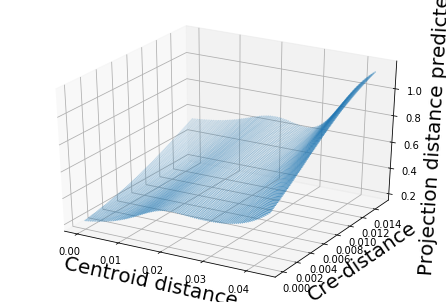

In [9]:
%matplotlib inline
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[4]].loss_surface_cv)
#plt.savefig('/Users/samsonkoelle/isocortexsurface')

In [10]:
    
def get_embedding_cv(surface, dists, cre_distances_cv):
    
    ntrain = dists.shape[0]
    norms = surface.norms
    leaf_pairs = np.asarray(np.where(~np.isnan(cre_distances_cv))).transpose()
    nlp = leaf_pairs.shape[0]
    
    losses = np.zeros((ntrain, ntrain))
    for i in range(nlp):
        d_ij = dists[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[0]
        p_ij = cre_distances_cv[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[1]
        losses[leaf_pairs[i][0]][leaf_pairs[i][1]] = surface.predict(np.asarray([[d_ij, p_ij]]))
      
    losses[np.where(losses == 0)] = np.nan
    
    return(losses)


In [11]:
for m in range(len(list(connectivity_data.structure_datas.keys()))):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].smoothed_losses = get_embedding_cv(surface = connectivity_data.structure_datas[sid].loss_surface_cv,
                                                                              dists = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2,
                                                                              cre_distances_cv = connectivity_data.structure_datas[sid].loss_surface_cv.cre_distances_cv)
# connectivity_data.leaf2_index_matrices = get_indices_2ormore(connectivity_data.leafs)
# connectivity_data.creleaf2_index_matrices = get_indices_2ormore(connectivity_data.creleaf_combos)
connectivity_data.creleaf2_evalindices = get_eval_indices(connectivity_data.creleaf2_index_matrices)


In [12]:
class Crossval:
    
    def __init__(self):
        2+2
        

def get_sumcre_combos(connectivity_data):

    #connectivity_data = self
    #leafs = self.leafs
    creline = connectivity_data.creline
    crestrs = {}
    crestrs_merged = {}

    major_structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    for sid in major_structure_ids:
        strs = connectivity_data.structure_datas[sid].summary_structures
        crestrs[sid] = np.asarray(np.vstack([strs, creline[sid]]), dtype=str).transpose()
        crestrs_merged[sid] = [crestrs[sid][:, 0][i] + crestrs[sid][:, 1][i] for i in range(crestrs[sid].shape[0])]
        crestrs_merged[sid] = np.asarray(crestrs_merged[sid])
    connectivity_data.crestrs_combos = crestrs_merged
    return(connectivity_data)
connectivity_data = get_sumcre_combos(connectivity_data)

connectivity_data.crestr2_index_matrices = get_indices_2ormore(connectivity_data.crestrs_combos)
summary_structures = {}

for sid in major_structure_ids:
    summary_structures[sid] = connectivity_data.structure_datas[sid].summary_structures
    
connectivity_data.summary_structures = summary_structures#get_indices_2ormore(connectivity_data.leafs)

connectivity_data.str2_index_matrices = get_indices_2ormore(connectivity_data.summary_structures)

In [13]:
twostage_leaf_creleaf2 = Crossval()

gammas = np.asarray([0.001,0.01,0.1,1,10,100,1000,10000])
#gammas = np.asarray([0.1,.5,1,2,10,20,40])
loocvpredictions = {}
reg_proj_norm= {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    loocvpredictions[sid] = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       connectivity_data.structure_datas[sid].smoothed_losses,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       #pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.leaf2_index_matrices[sid], 
                                                                                       connectivity_data.leaf2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])
            
    
    
a= [list(range(len(gammas)))]
keys = np.asarray(list(itertools.product(*a)))

twostage_leaf_creleaf2.loocvpredictions = loocvpredictions
twostage_leaf_creleaf2.losses = get_loss(reg_proj_norm, twostage_leaf_creleaf2.loocvpredictions,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
twostage_leaf_creleaf2.bestgamma  = get_best_hyperparameters(twostage_leaf_creleaf2.losses,keys)
twostage_leaf_creleaf2.meanloss = get_loss_best_hyp(twostage_leaf_creleaf2.losses, twostage_leaf_creleaf2.bestgamma)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


In [14]:
twostage_leaf_creleaf2.meanloss, twostage_leaf_creleaf2.bestgamma

(array([0.03862558, 0.4966726 , 0.08387246, 0.21983532, 0.12747673,
        0.11226157, 0.16358549, 0.05566028, 0.22811406, 0.13767042,
        0.04806401, 0.32689735]), array([[5],
        [0],
        [5],
        [5],
        [5],
        [4],
        [5],
        [5],
        [4],
        [4],
        [5],
        [4]]))

In [13]:
twostage_leaf_creleaf2.meanloss, twostage_leaf_creleaf2.bestgamma

(array([0.03999995, 0.4966726 , 0.07966374, 0.20991725, 0.1278844 ,
        0.11226157, 0.15882309, 0.05856719, 0.22679328, 0.13541742,
        0.05153798, 0.31950874]), array([[6],
        [0],
        [5],
        [6],
        [6],
        [4],
        [5],
        [6],
        [5],
        [5],
        [6],
        [3]]))

In [16]:
nw_leaf_creleaf2 = Crossval()

gammas = np.asarray([0.001,0.01,0.1,1,10,100,1000,10000])

#gammas = np.asarray([0.1,.5,1,2,10,20,40])
loocvpredictions = {}
reg_proj_norm= {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    pds = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2
    loocvpredictions[sid] = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       #connectivity_data.structure_datas[sid].smoothed_losses,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.leaf2_index_matrices[sid], 
                                                                                       connectivity_data.leaf2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])

a= [list(range(len(gammas)))]
keys = np.asarray(list(itertools.product(*a)))

nw_leaf_creleaf2.loocvpredictions = loocvpredictions
nw_leaf_creleaf2.losses = get_loss(reg_proj_norm, nw_leaf_creleaf2.loocvpredictions,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
nw_leaf_creleaf2.bestgamma  = get_best_hyperparameters(nw_leaf_creleaf2.losses,keys)
nw_leaf_creleaf2.meanloss = get_loss_best_hyp(nw_leaf_creleaf2.losses, nw_leaf_creleaf2.bestgamma)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


In [17]:
nw_leaf_creleaf2.meanloss, nw_leaf_creleaf2.bestgamma

(array([0.03945859, 0.4966726 , 0.11269334, 0.240828  , 0.18424232,
        0.12923566, 0.2011691 , 0.06372702, 0.26415894, 0.25605966,
        0.08174782, 0.31461163]), array([[1],
        [0],
        [1],
        [2],
        [2],
        [3],
        [1],
        [0],
        [4],
        [2],
        [2],
        [2]]))

In [15]:
nw_leaf_creleaf2.meanloss, nw_leaf_creleaf2.bestgamma

(array([0.06492248, 0.4966726 , 0.12877972, 0.23367772, 0.18424232,
        0.12156122, 0.19349936, 0.07775228, 0.25703143, 0.25605966,
        0.08174782, 0.31461163]), array([[0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [3],
        [0],
        [0],
        [0]]))

In [18]:
nw_creleaf_creleaf2 = Crossval()

gammas = np.asarray([0.001,0.01,0.1,1,10,100,1000,10000])

#gammas = np.asarray([0.1,.5,1,2,10,20,40])
loocvpredictions = {}
reg_proj_norm= {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    pds = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2
    loocvpredictions[sid] = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       #connectivity_data.structure_datas[sid].smoothed_losses,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.creleaf2_index_matrices[sid], 
                                                                                       connectivity_data.creleaf2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])

a= [list(range(len(gammas)))]
keys = np.asarray(list(itertools.product(*a)))

nw_creleaf_creleaf2.loocvpredictions = loocvpredictions
nw_creleaf_creleaf2.losses = get_loss(reg_proj_norm, nw_creleaf_creleaf2.loocvpredictions,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
nw_creleaf_creleaf2.bestgamma  = get_best_hyperparameters(nw_creleaf_creleaf2.losses,keys)
nw_creleaf_creleaf2.meanloss = get_loss_best_hyp(nw_creleaf_creleaf2.losses, nw_creleaf_creleaf2.bestgamma)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


In [19]:
nw_creleaf_creleaf2.meanloss, nw_creleaf_creleaf2.bestgamma

(array([0.04951634, 0.4966726 , 0.1013065 , 0.25932422, 0.15073582,
        0.11942033, 0.22439401, 0.07448767, 0.2385843 , 0.19429965,
        0.06370823, 0.57225383]), array([[0],
        [0],
        [1],
        [2],
        [2],
        [2],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0]]))

In [35]:
nw_creleaf_creleaf2.meanloss, nw_creleaf_creleaf2.bestgamma

(array([0.04951634, 0.4966726 , 0.10827024, 0.25932422, 0.15073582,
        0.11942033, 0.23823622, 0.0798464 , 0.2385843 , 0.19568441,
        0.06782042, 0.57384959]), array([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]]))

In [20]:
nw_crestr_creleaf2 = Crossval()

gammas = np.asarray([0.001,0.01,0.1,1,10,100,1000,10000])

#gammas = np.asarray([0.1,.5,1,2,10,20,40])
loocvpredictions = {}
reg_proj_norm= {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    pds = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2
    loocvpredictions[sid] = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       #connectivity_data.structure_datas[sid].smoothed_losses,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.crestr2_index_matrices[sid], 
                                                                                       connectivity_data.crestr2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])

a= [list(range(len(gammas)))]
keys = np.asarray(list(itertools.product(*a)))

nw_crestr_creleaf2.loocvpredictions = loocvpredictions
nw_crestr_creleaf2.losses = get_loss(reg_proj_norm, nw_crestr_creleaf2.loocvpredictions,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
nw_crestr_creleaf2.bestgamma  = get_best_hyperparameters(nw_crestr_creleaf2.losses,keys)
nw_crestr_creleaf2.meanloss = get_loss_best_hyp(nw_crestr_creleaf2.losses, nw_crestr_creleaf2.bestgamma)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


In [21]:
nw_crestr_creleaf2.meanloss, nw_crestr_creleaf2.bestgamma

(array([0.04951634, 0.4966726 , 0.09323181, 0.25932422, 0.14013186,
        0.11997462, 0.22439401, 0.07448767, 0.2385843 , 0.19429965,
        0.06370823, 0.57237373]), array([[0],
        [0],
        [1],
        [2],
        [2],
        [2],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0]]))

In [19]:
nw_crestr_creleaf2.meanloss, nw_crestr_creleaf2.bestgamma

(array([0.04951634, 0.4966726 , 0.10487407, 0.25932422, 0.14013186,
        0.11997462, 0.23823622, 0.0798464 , 0.2385843 , 0.19568441,
        0.06782042, 0.57386411]), array([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]]))

In [22]:
nw_str_creleaf2 = Crossval()

gammas = np.asarray([0.001,0.01,0.1,1,10,100,1000,10000])

#gammas = np.asarray([0.1,.5,1,2,10,20,40])
loocvpredictions = {}
reg_proj_norm= {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    pds = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2
    loocvpredictions[sid] = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       #connectivity_data.structure_datas[sid].smoothed_losses,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.str2_index_matrices[sid], 
                                                                                       connectivity_data.str2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])

a= [list(range(len(gammas)))]
keys = np.asarray(list(itertools.product(*a)))

nw_str_creleaf2.loocvpredictions = loocvpredictions
nw_str_creleaf2.losses = get_loss(reg_proj_norm, nw_str_creleaf2.loocvpredictions,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
nw_str_creleaf2.bestgamma  = get_best_hyperparameters(nw_str_creleaf2.losses,keys)
nw_str_creleaf2.meanloss = get_loss_best_hyp(nw_str_creleaf2.losses, nw_str_creleaf2.bestgamma)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


In [23]:
nw_str_creleaf2.meanloss,nw_str_creleaf2.bestgamma 

(array([0.03945859, 0.4966726 , 0.12370116, 0.240828  , 0.1979489 ,
        0.13912938, 0.2011691 , 0.06372702, 0.26415894, 0.25605966,
        0.08174782, 0.31487254]), array([[1],
        [0],
        [1],
        [2],
        [2],
        [3],
        [1],
        [0],
        [4],
        [2],
        [2],
        [2]]))

In [22]:
nw_str_creleaf2.meanloss,nw_str_creleaf2.bestgamma 

(array([0.06492248, 0.4966726 , 0.13537567, 0.23367772, 0.19731015,
        0.13114806, 0.19349936, 0.07775228, 0.25703143, 0.25605966,
        0.08174782, 0.31487254]), array([[0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [3],
        [0],
        [0],
        [0]]))

In [26]:
for m in range(12):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv_str = get_loss_surface_cv(connectivity_data.structure_datas[sid].reg_proj_norm,
                                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                                 connectivity_data.creline[sid],
                                                                                                 connectivity_data.summary_structures[sid],
                                                                                                 frac_learn[m],
                                                                                                 gamma = 10000)
    
    

for m in range(len(list(connectivity_data.structure_datas.keys()))):
    sid = major_structure_ids[m]
    print(m)
    connectivity_data.structure_datas[sid].smoothed_losses_str = get_embedding_cv(surface = connectivity_data.structure_datas[sid].loss_surface_cv_str,
                                                                              dists = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2,
                                                                              cre_distances_cv = connectivity_data.structure_datas[sid].loss_surface_cv_str.cre_distances_cv)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
2

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
0
1
2
3
4
5
6
7
8
9
10
11


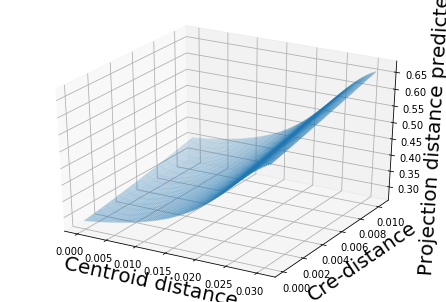

In [27]:
%matplotlib inline
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[4]].loss_surface_cv_str)
#plt.savefig('/Users/samsonkoelle/isocortexsurface')

In [28]:
twostage_str_creleaf2 = Crossval()

gammas = np.asarray([0.001,0.01,0.1,1,10,100,1000,10000])

#gammas = np.asarray([0.1,.5,1,2,10,20,40])
loocvpredictions = {}
reg_proj_norm= {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    loocvpredictions[sid] = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       connectivity_data.structure_datas[sid].smoothed_losses_str,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       #pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.str2_index_matrices[sid], 
                                                                                       connectivity_data.str2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])
            
    
    
a= [list(range(len(gammas)))]
keys = np.asarray(list(itertools.product(*a)))

twostage_str_creleaf2.loocvpredictions = loocvpredictions
twostage_str_creleaf2.losses = get_loss(reg_proj_norm, twostage_str_creleaf2.loocvpredictions,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
twostage_str_creleaf2.bestgamma  = get_best_hyperparameters(twostage_str_creleaf2.losses,keys)
twostage_str_creleaf2.meanloss = get_loss_best_hyp(twostage_str_creleaf2.losses, twostage_str_creleaf2.bestgamma)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


In [29]:
twostage_str_creleaf2.meanloss, twostage_str_creleaf2.bestgamma 

(array([0.01315335, 0.4966726 , 0.07444855, 0.20388062, 0.18813393,
        0.10863114, 0.11822382, 0.04655035, 0.20518477, 0.11938663,
        0.04842225, 0.28319319]), array([[6],
        [0],
        [6],
        [4],
        [6],
        [4],
        [4],
        [6],
        [5],
        [4],
        [6],
        [4]]))

In [29]:
twostage_str_creleaf2.meanloss, twostage_str_creleaf2.bestgamma 

(array([0.02492916, 0.4966726 , 0.07902428, 0.20388062, 0.12306053,
        0.10863114, 0.11822382, 0.04860441, 0.20678294, 0.11938663,
        0.0491806 , 0.28319319]), array([[4],
        [0],
        [5],
        [4],
        [6],
        [4],
        [4],
        [5],
        [4],
        [4],
        [5],
        [4]]))

In [34]:
rezzies = np.asarray([nw_str_creleaf2.meanloss, 
            nw_crestr_creleaf2.meanloss, 
            nw_leaf_creleaf2.meanloss, 
            nw_creleaf_creleaf2.meanloss, 
            twostage_str_creleaf2.meanloss  ,        
            twostage_leaf_creleaf2.meanloss]).transpose()

In [48]:
leafresults = pd.DataFrame(rezzies[[4,7,2,1,10,9,11,3,5,8,6,0]], columns = ['NW w/in SS',
                               'NW w/in cre-SS combo',
                              'NW w/in leaf',
                              'NW w/in cre-leaf combo',
                              '2-stage w/in SS',
                              '2-stage w/in leaf'],
            index = np.asarray(major_structures)[[4,7,2,1,10,9,11,3,5,8,6,0]])

In [47]:
print(leafresults.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  NW w/in SS &  NW w/in cre-SS combo &  NW w/in leaf &  NW w/in cre-leaf combo &  2-stage w/in SS &  2-stage w/in leaf \\
\midrule
Isocortex &    0.197949 &              0.140132 &      0.184242 &                0.150736 &         0.123061 &           0.127477 \\
OLF       &    0.063727 &              0.074488 &      0.063727 &                0.074488 &         0.048604 &           0.055660 \\
HPF       &    0.123701 &              0.093232 &      0.112693 &                0.101307 &         0.079024 &           0.083872 \\
CTXsp     &    0.496673 &              0.496673 &      0.496673 &                0.496673 &         0.496673 &           0.496673 \\
STR       &    0.081748 &              0.063708 &      0.081748 &                0.063708 &         0.049181 &           0.048064 \\
PAL       &    0.256060 &              0.194300 &      0.256060 &                0.194300 &         0.119387 &           0.137670 \\
TH        &    0.314873 &        

In [42]:
np.asarray([nw_str_creleaf2.meanloss, 
            nw_crestr_creleaf2.meanloss, 
            nw_leaf_creleaf2.meanloss, 
            nw_creleaf_creleaf2.meanloss, 
            twostage_leaf_creleaf2.meanloss, 
            twostage_str_creleaf2.meanloss]).transpose()

array([[0.06492248, 0.04951634, 0.06492248, 0.04951634, 0.03999995,
        0.01315335],
       [0.4966726 , 0.4966726 , 0.4966726 , 0.4966726 , 0.4966726 ,
        0.4966726 ],
       [0.13537567, 0.10487407, 0.12877972, 0.10827024, 0.07966374,
        0.07444855],
       [0.23367772, 0.25932422, 0.23367772, 0.25932422, 0.20991725,
        0.20388062],
       [0.19731015, 0.14013186, 0.18424232, 0.15073582, 0.1278844 ,
        0.18813393],
       [0.13114806, 0.11997462, 0.12156122, 0.11942033, 0.11226157,
        0.10863114],
       [0.19349936, 0.23823622, 0.19349936, 0.23823622, 0.15882309,
        0.11822382],
       [0.07775228, 0.0798464 , 0.07775228, 0.0798464 , 0.05856719,
        0.04655035],
       [0.25703143, 0.2385843 , 0.25703143, 0.2385843 , 0.22679328,
        0.20518477],
       [0.25605966, 0.19568441, 0.25605966, 0.19568441, 0.13541742,
        0.11938663],
       [0.08174782, 0.06782042, 0.08174782, 0.06782042, 0.05153798,
        0.04842225],
       [0.31487254, 0

In [37]:
nw_str_creleaf2

In [ ]:
np.asarray([nw_str_creleaf2.meanloss, 
            nw_crestr_creleaf2.meanloss, 
            nw_creleaf_creleaf2.meanloss,
            twostage_leaf_creleaf2.meanloss, ]).transpose()
np.asarray([nw_str_creleaf2.meanloss, 
            nw_crestr_creleaf2.meanloss, 
            nw_creleaf_creleaf2.meanloss,  
            twostage_leaf_creleaf2.meanloss ]).transpose()

In [30]:
nw_creleaf_creleaf2 = Crossval()

gammas = np.asarray([0.1,.5,1,2,10,20,40])
loocvpredictions = {}
reg_proj_norm= {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    pds = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2
    loocvpredictions[sid] = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       #connectivity_data.structure_datas[sid].smoothed_losses,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.crest2_index_matrices[sid], 
                                                                                       connectivity_data.creleaf2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])

a= [list(range(len(gammas)))]
keys = np.asarray(list(itertools.product(*a)))

nw_creleaf_creleaf2.loocvpredictions = loocvpredictions
nw_creleaf_creleaf2.losses = get_loss(reg_proj_norm, nw_creleaf_creleaf2.loocvpredictions,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
nw_creleaf_creleaf2.bestgamma  = get_best_hyperparameters(nw_creleaf_creleaf2.losses,keys)
nw_creleaf_creleaf2.meanloss = get_loss_best_hyp(nw_creleaf_creleaf2.losses, nw_creleaf_creleaf2.bestgamma)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

AttributeError: 'ConnectivityData' object has no attribute 'crest2_index_matrices'

0
1
2
3
4
5
6
7
8
9
10
11


In [34]:
gammas = np.asarray([0.1,.5,1,2,10,20,40])
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    pds = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       #connectivity_data.structure_datas[sid].smoothed_losses,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.leaf2_index_matrices[sid], 
                                                                                       connectivity_data.leaf2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])
a= [list(range(7))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_norm= {}
nwloocv_leaf_leaf2 = {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2


losses_leaf_leaf2 = get_loss(reg_proj_norm, nwloocv_leaf_leaf2,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
bestgamma_nw_leaf_creleaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_creleaf2 = get_loss_best_hyp(losses_leaf_leaf2, bestgamma_nw_leaf_creleaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


In [35]:
meanloss_nw_leaf_leaf2, bestgamma_nw_leaf_leaf2

(array([0.06492248, 0.4966726 , 0.12877972, 0.23367772, 0.18424232,
        0.12156122, 0.19349936, 0.07775228, 0.25703143, 0.25605966,
        0.08174782, 0.31461163]), array([[0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [3],
        [0],
        [0],
        [0]]))

In [ ]:
gammas = np.asarray([0.1,.5,1,2,10,20,40])
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    pds = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       #connectivity_data.structure_datas[sid].smoothed_losses,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.creleaf2_index_matrices[sid], 
                                                                                       connectivity_data.creleaf2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])
a= [list(range(7))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_norm= {}
nwloocv_leaf_leaf2 = {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2


losses_leaf_leaf2 = get_loss(reg_proj_norm, nwloocv_leaf_leaf2,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
bestgamma_2stage_creleaf_creleaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_2stage_creleaf_creleaf2 = get_loss_best_hyp(losses_leaf_leaf2, bestgamma_2stage_creleaf_creleaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


In [ ]:
meanloss_2stage_creleaf_creleaf2, bestgamma_2stage_creleaf_creleaf2

In [17]:

def get_summaryleaf_combos(connectivity_data):

    #connectivity_data = self
    #leafs = self.leafs
    creline = connectivity_data.creline
    crestrs = {}
    crestrs_merged = {}

    major_structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    for sid in major_structure_ids:
        strs = connectivity_data.structure_datas[sid].summary_structures
        crestrs[sid] = np.asarray(np.vstack([strs, creline[sid]]), dtype=str).transpose()
        crestrs_merged[sid] = [crestrs[sid][:, 0][i] + crestrs[sid][:, 1][i] for i in range(crestrs[sid].shape[0])]
        crestrs_merged[sid] = np.asarray(crestrs_merged[sid])
    connectivity_data.crestrs_combos = crestrs_merged
    return(connectivity_data)
connectivity_data = get_summaryleaf_combos(connectivity_data)

connectivity_data.crestr2_index_matrices = get_indices_2ormore(connectivity_data.crestrs_combos)

In [28]:
gammas = np.asarray([0.1,.5,1,2,10,20,40])
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    pds = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       #connectivity_data.structure_datas[sid].smoothed_losses,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.crestr2_index_matrices[sid], 
                                                                                       connectivity_data.crestr2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])
a= [list(range(7))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_norm= {}
nwloocv_leaf_leaf2 = {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2


losses_leaf_leaf2 = get_loss(reg_proj_norm, nwloocv_leaf_leaf2,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
bestgamma_nw_cresum_creleaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2_2stage = get_loss_best_hyp(losses_leaf_leaf2, bestgamma_cresum_leaf_leaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [27 29] m [27 29]
e [27 29] m [27 29]
e [27 29] m [27 29]
e [27 29] m [27 29]
e [27 29] m [27 29]
e [27 29] m [27 29]
e [27 29] m [27 29]
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [1 4] m [1 4]
e [1 4] m [1 4]
e [1 4] m [1 4]
e [1 4] m [1 4]
e [1 4] m [1 4]
e [1 4] m [1 4]
e [1 4] m [1 4]
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m [

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [11 34 87] m [11 34 87]
e [11 34 87] m [11 34 87]
e [11 34 87] m [11 34 87]
e [11 34 87] m [11 34 87]
e [11 34 87] m [11 34 87]
e [11 34 87] m [11 34 87]
e [11 34 87] m [11 34 87]
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [ 80 115] m [ 80 115]
e [ 80 115] m [ 80 115]
e [ 80 115] m [ 80 115]
e [ 80 115] m [ 80 115]
e [ 80 115] m [ 80 115]
e [ 80 115] m [ 80 115]
e [ 80 115] m [ 80 115]
e [55 60] m [55 60]
e [55 60] m [55 60]
e [55 60] m [55 60]
e [55 60] m [55 60]
e [55 60] m [55 60]
e [55 60] m [55 60]
e [55 60] m [55 60]
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e 

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


e [ 24  30  94 106] m [ 24  30  94 106]
e [ 24  30  94 106] m [ 24  30  94 106]
e [ 24  30  94 106] m [ 24  30  94 106]
e [ 24  30  94 106] m [ 24  30  94 106]
e [ 24  30  94 106] m [ 24  30  94 106]
e [ 24  30  94 106] m [ 24  30  94 106]
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [19 75] m [19 75]
e [19 75] m [19 75]
e [19 75] m [19 75]
e [19 75] m [19 75]
e [19 75] m [19 75]
e [19 75] m [19 75]
e [19 75] m [19 75]
e [ 18  81 114] m [ 18  81 114]
e [ 18  81 114] m [ 18  81 114]
e [ 18  81 114] m [ 18  81 114]
e [ 18  81 114] m [ 18  81 114]
e [ 18  81 114] m [ 18  81 114]
e [ 18  81 114] m [ 18  81 114]
e [ 18  81 114] m [ 18  81 114]
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [22 33 56 71] m [22 33 56 71]
e [22 33 56 71] m [22 33 56 71]
e [22 33 56 71] m [22 33 56 71]
e [22 33 56 71] m [22 33 56 71]
e [22 33 56 71] m [22 33 56 71]
e [22 33 56 71] m [22 33 5

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [62 73 84] m [62 73 84]
e [62 73 84] m [62 73 84]
e [62 73 84] m [62 73 84]
e [62 73 84] m [62 73 84]
e [62 73 84] m [62 73 84]
e [62 73 84] m [62 73 84]
e [62 73 84] m [62 73 84]
e [ 1 19 54] m [ 1 19 54]
e [ 1 19 54] m [ 1 19 54]
e [ 1 19 54] m [ 1 19 54]
e [ 1 19 54] m [ 1 19 54]
e [ 1 19 54] m [ 1 19 54]
e [ 1 19 54] m [ 1 19 54]
e [ 1 19 54] m [ 1 19 54]
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [42 72] m [42 72]
e [42 72] m [42 72]
e [42 72] m [42 72]
e [42 72] m [42 72]
e [42 72] m [42 72]
e [42 72] m [42 72]
e [42 72] m [42 72]
e [15 61] m [15 61]
e [15 61] m [15 61]
e [15 61] m [15 61]
e [15 61] m [15 61]
e [15 61] m [15 61]
e [15 61] m [15 61]
e [15 61] m [15 61]
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


e [846 857] m [846 857]
e [846 857] m [846 857]
e [846 857] m [846 857]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [276 575] m [276 575]
e [276 575] m [276 575]
e [276 575] m [276 575]
e [276 575] m [276 575]
e [276 575] m [276 575]
e [276 575] m [276 575]
e [276 575] m [276 575]
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e []

e [ 313  535  579  589  938  941 1075] m [ 313  535  579  589  938  941 1075]
e [ 313  535  579  589  938  941 1075] m [ 313  535  579  589  938  941 1075]
e [ 313  535  579  589  938  941 1075] m [ 313  535  579  589  938  941 1075]
e [ 313  535  579  589  938  941 1075] m [ 313  535  579  589  938  941 1075]
e [ 313  535  579  589  938  941 1075] m [ 313  535  579  589  938  941 1075]
e [ 313  535  579  589  938  941 1075] m [ 313  535  579  589  938  941 1075]
e [ 313  535  579  589  938  941 1075] m [ 313  535  579  589  938  941 1075]
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [152 528 616] m [152 528 616]
e [152 528 616] m [152 528 616]
e [152 528 616] m [152 528 616]
e [152 528 616] m [152 528 616]
e [152 528 616] m [152 528 616]
e [152 528 616] m [152 528 616]
e [152 528 616] m [152 528 616]
e [122 135 502 678 862] m [122 135 502 678 862]
e [122 135 502 678 862] m [122 135 502 678 862]
e [122 135 502 678 862] m [122 135 502 678 862]
e [122 135 502 6

e [516 750] m [516 750]
e [516 750] m [516 750]
e [516 750] m [516 750]
e [516 750] m [516 750]
e [516 750] m [516 750]
e [516 750] m [516 750]
e [516 750] m [516 750]
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [617 974] m [617 974]
e [617 974] m [617 974]
e [617 974] m [617 974]
e [617 974] m [617 974]
e [617 974] m [617 974]
e [617 974] m [617 974]
e [617 974] m [617 974]
e [ 217  867 1101] m [ 217  867 1101]
e [ 217  867 1101] m [ 217  867 1101]
e [ 217  867 1101] m [ 217  867 1101]
e [ 217  867 1101] m [ 217  867 1101]
e [ 217  867 1101] m [ 217  867 1101]
e [ 217  867 1101] m [ 217  867 1101]
e [ 217  867 1101] m [ 217  867 1101]
e [ 852 1051] m [ 852 1051]
e [ 852 1051] m [ 852 1051]
e [ 852 1051] m [ 852 1051]
e [ 852 1051] m [ 852 1051]
e [ 852 1051] m [ 852 1051]
e [ 852 1051] m [ 852 1051]
e [ 852 1051] m [ 852 1051]
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e 

e [  21  145  197  201  207  249  291  351  490  506  582  607  666  669
  687  771  791  802  804  918  919  932  945  971 1063] m [  21  145  197  201  207  249  291  351  490  506  582  607  666  669
  687  771  791  802  804  918  919  932  945  971 1063]
e [  21  145  197  201  207  249  291  351  490  506  582  607  666  669
  687  771  791  802  804  918  919  932  945  971 1063] m [  21  145  197  201  207  249  291  351  490  506  582  607  666  669
  687  771  791  802  804  918  919  932  945  971 1063]
e [  21  145  197  201  207  249  291  351  490  506  582  607  666  669
  687  771  791  802  804  918  919  932  945  971 1063] m [  21  145  197  201  207  249  291  351  490  506  582  607  666  669
  687  771  791  802  804  918  919  932  945  971 1063]
e [  41   74   93  101  121  148  305  321  346  348  394  398  410  444
  492  512  573  630  632  696  697  765  778  811  829  863  883 1029
 1086 1100 1125] m [  41   74   93  101  121  148  305  321  346  348  394  

e [ 16 610 983] m [ 16 610 983]
e [ 16 610 983] m [ 16 610 983]
e [ 16 610 983] m [ 16 610 983]
e [ 16 610 983] m [ 16 610 983]
e [ 16 610 983] m [ 16 610 983]
e [ 16 610 983] m [ 16 610 983]
e [ 16 610 983] m [ 16 610 983]
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [   1  169  439  591  754  787 1093] m [   1  169  439  591  754  787 1093]
e [   1  169  439  591  754  787 1093] m [   1  169  439  591  754  787 1093]
e [   1  169  439  591  754  787 1093] m [   1  169  439  591  754  787 1093]
e [   1  169  439  591  754  787 1093] m [   1  169  439  591  754  787 1093]
e [   1  169  439  591  754  787 1093] m [   1  169  439  591  754  787 1093]
e [   1  169  439  591  754  787 1093] m [   1  169  439  591  754  787 1093]
e [   1  169  439  591  754  787 1093] m [   1  169  439  591  754  787 1093]
e [ 111  214  303  316  357  411  473  487  521  648  698  898  910  933
  934 1044] m [ 111  214  303  316  357  411  473  487  521  648  698  898  910  933
  

e [237 354 755] m [237 354 755]
e [237 354 755] m [237 354 755]
e [237 354 755] m [237 354 755]
e [237 354 755] m [237 354 755]
e [237 354 755] m [237 354 755]
e [237 354 755] m [237 354 755]
e [237 354 755] m [237 354 755]
e [ 27  58 499 634 720] m [ 27  58 499 634 720]
e [ 27  58 499 634 720] m [ 27  58 499 634 720]
e [ 27  58 499 634 720] m [ 27  58 499 634 720]
e [ 27  58 499 634 720] m [ 27  58 499 634 720]
e [ 27  58 499 634 720] m [ 27  58 499 634 720]
e [ 27  58 499 634 720] m [ 27  58 499 634 720]
e [ 27  58 499 634 720] m [ 27  58 499 634 720]
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [209 580] m [209 580]
e [209 580] m [209 580]
e [209 580] m [209 580]
e [209 580] m [209 580]
e [209 580] m [209 580]
e [209 580] m [209 580]
e [209 580] m [209 580]
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [ 247  964 1104] m [ 247  964 1104]
e [ 247  964 1104] m [ 2

e [577 692 812] m [577 692 812]
e [577 692 812] m [577 692 812]
e [577 692 812] m [577 692 812]
e [577 692 812] m [577 692 812]
e [577 692 812] m [577 692 812]
e [577 692 812] m [577 692 812]
e [577 692 812] m [577 692 812]
e [ 497  522  745  877  935 1002] m [ 497  522  745  877  935 1002]
e [ 497  522  745  877  935 1002] m [ 497  522  745  877  935 1002]
e [ 497  522  745  877  935 1002] m [ 497  522  745  877  935 1002]
e [ 497  522  745  877  935 1002] m [ 497  522  745  877  935 1002]
e [ 497  522  745  877  935 1002] m [ 497  522  745  877  935 1002]
e [ 497  522  745  877  935 1002] m [ 497  522  745  877  935 1002]
e [ 497  522  745  877  935 1002] m [ 497  522  745  877  935 1002]
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [185 726 848 943] m [185 726 848 943]
e [185 726 848 943] m [185 726 848 943]
e [185 726

e [ 530  759  785 1082] m [ 530  759  785 1082]
e [ 530  759  785 1082] m [ 530  759  785 1082]
e [ 530  759  785 1082] m [ 530  759  785 1082]
e [ 530  759  785 1082] m [ 530  759  785 1082]
e [ 530  759  785 1082] m [ 530  759  785 1082]
e [ 530  759  785 1082] m [ 530  759  785 1082]
e [ 530  759  785 1082] m [ 530  759  785 1082]
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [ 334  989 1092] m [ 334  989 1092]
e [ 334  989 1092] m [ 334  989 1092]
e [ 334  989 1092] m [ 334  989 1092]
e [ 334  989 1092] m [ 334  989 1092]
e [ 334  989 1092] m [ 334  989 1092]
e [ 334  989 1092] m [ 334  989 1092]
e [ 334  989 1092] m [ 334  989 1092]
e [ 96 226 832] m [ 96 226 832]
e [ 96 226 832] m [ 96 226 832]
e [ 96 226 832] m [ 96 226 832]
e [ 96 226 832] m [ 96 226 832]
e [ 96 226 832] m [ 96 226 832]
e [ 96 226 832] m [ 96 226 832]
e [ 96 226 832] m [ 96 226 832]
e [560 708] m [560 708]
e [560 708] m [560 708]
e [560 708] m [560 708]
e [560 708] m [560 708]
e [560 7

e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [  0 107 611] m [  0 107 611]
e [  0 107 611] m [  0 107 611]
e [  0 107 611] m [  0 107 611]
e [  0 107 611] m [  0 107 611]
e [  0 107 611] m [  0 107 611]
e [  0 107 611] m [  0 107 611]
e [  0 107 611] m [  0 107 611]
e [ 92 344] m [ 92 344]
e [ 92 344] m [ 92 344]
e [ 92 344] m [ 92 344]
e [ 92 344] m [ 92 344]
e [ 92 344] m [ 92 344]
e [ 92 344] m [ 92 344]
e [ 92 344] m [ 92 344]
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [242 420 685] m [242 420 685]
e [242 420 685] m [242 420 685]
e [242 420 685] m [242 420 685]
e [242 420 685] m [242 420 685]
e [242 420 685] m [242 420 685]
e [242 420 685] m [242 420 685]
e [242 420 685] m [242 420 685]
e [136 299] m [136 299]
e [136 299] m [136 299]
e [136 299] m [136 299]
e [136 299] m [136 299]
e [136 2

e [ 389 1091] m [ 389 1091]
e [ 389 1091] m [ 389 1091]
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [ 881 1007] m [ 881 1007]
e [ 881 1007] m [ 881 1007]
e [ 881 1007] m [ 881 1007]
e [ 881 1007] m [ 881 1007]
e [ 881 1007] m [ 881 1007]
e [ 881 1007] m [ 881 1007]
e [ 881 1007] m [ 881 1007]
e [133 424 445] m [133 424 445]
e [133 424 445] m [133 424 445]
e [133 424 445] m [133 424 445]
e [133 424 445] m [133 424 445]
e [133 424 445] m [133 424 445]
e [133 424 445] m [133 424 445]
e [133 424 445] m [133 424 445]
e [380 730 794] m [380 730 794]
e [380 730 794] m [380 730 794]
e [380 730 794] m [380 730 794]
e [380 730 794] m [380 730 794]
e [380 730 794] m [380 730 794]
e [380 730 794] m [380 730 794]
e [380 730 794] m [380 730 794]
e [  90  526  670  792 1088] m [  90  526  670  792 1088]
e [  90  526  670  792 1088] m [  90  526  670  792 1088]
e [  90  526  670  792 1088] m [  90  526  670  792 1088]
e [  90  526  670  792 1088] m [  90  526  670  792 1088

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [37 42 56] m [37 42 56]
e [37 42 56] m [37 42 56]
e [37 42 56] m [37 42 56]
e [37 42 56] m [37 42 56]
e [37 42 56] m [37 42 56]
e [37 42 56] m [37 42 56]
e [37 42 56] m [37 42 56]
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m [

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [13 16] m [13 16]
e [13 16] m [13 16]
e [13 16] m [13 16]
e [13 16] m [13 16]
e [13 16] m [13 16]
e [13 16] m [13 16]
e [13 16] m [13 16]
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [ 9 23 33] m [ 9 23 33]
e [ 9 23 33] m [ 9 23 33]
e [ 9 23 33] m [ 9 23 33]
e [ 9 23 33] m [ 9 23 33]
e [ 9 23 33] m [ 9 23 33]
e [ 9 23 33] m [ 9 2

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [19 60] m [19 60]
e [19 60] m [19 60]
e [19 60] m [19 60]
e [19 60] m [19 60]
e [19 60] m [19 60]
e [19 60] m [19 60]
e [19 60] m [19 60]
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [ 3 20 59] m [ 3 20 59]
e [ 3 20 59] m [ 3 20 59]
e [ 3 20 59] m [ 3 20 59]
e [ 3 20 59]

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


e [41 68] m [41 68]
e [41 68] m [41 68]
e [41 68] m [41 68]
e [41 68] m [41 68]
e [41 68] m [41 68]
e [41 68] m [41 68]
e [41 68] m [41 68]
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [ 8 26] m [ 8 26]
e [ 8 26] m [ 8 26]
e [ 8 26] m [ 8 26]
e [ 8 26] m [ 8 26]
e [ 8 26] m [ 8 26]
e [ 8 26] m [ 8 26]
e [ 8 26] m [ 8 26]
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


e [18 32] m [18 32]
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [ 9 51] m [ 9 51]
e [ 9 51] m [ 9 51]
e [ 9 51] m [ 9 51]
e [ 9 51] m [ 9 51]
e [ 9 51] m [ 9 51]
e [ 9 51] m [ 9 51]
e [ 9 51] m [ 9 51]
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [60 79] m [60 79]
e [60 79] m [60 79]
e [60 79] m [60 79]
e [60 79] m [60 79]
e [60 79] m [60 79]
e [60 79] m [60 79]
e [60 79] m [60 79]
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []


In [19]:
meanloss_nw_leaf_leaf2_2stage, best_gamma_leaf_leaf2

(array([0.04951634, 0.4966726 , 0.10487407, 0.25932422, 0.14013186,
        0.11997462, 0.23823622, 0.0798464 , 0.2385843 , 0.19568441,
        0.06782042, 0.57386411]), array([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]]))

In [20]:
summary_structures = {}
for sid in major_structure_ids:
    summary_structures[sid] = connectivity_data.structure_datas[sid].summary_structures
    
connectivity_data.summary_structures = summary_structures#get_indices_2ormore(connectivity_data.leafs)

connectivity_data.str2_index_matrices = get_indices_2ormore(connectivity_data.summary_structures)

In [22]:
gammas = np.asarray([0.1,.5,1,2,10,20,40])
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    pds = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       #connectivity_data.structure_datas[sid].smoothed_losses,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.str2_index_matrices[sid], 
                                                                                       connectivity_data.str2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])
a= [list(range(7))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_norm= {}
nwloocv_leaf_leaf2 = {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2


losses_leaf_leaf2 = get_loss(reg_proj_norm, nwloocv_leaf_leaf2,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2_2stage = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
m 0 3 0.003720867 0.008055458025002557
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
m 1 2 0.003720867 0.008605728374282284
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
m 2 3 0.003720867 0.002818744580114119
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 2  

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.n

m 2 6 0.004429725 0.005508238193424311
e [  8   9  18  19  20  22  24  30  33  39  41  42  56  71  74  75  76  79
  81  94  99 106 114 116] m [  8   9  18  19  20  22  24  30  33  39  41  42  56  71  74  75  76  79
  81  94  99 106 114 116]
e [  8   9  18  19  20  22  24  30  33  39  41  42  56  71  74  75  76  79
  81  94  99 106 114 116] m [  8   9  18  19  20  22  24  30  33  39  41  42  56  71  74  75  76  79
  81  94  99 106 114 116]
e [  8   9  18  19  20  22  24  30  33  39  41  42  56  71  74  75  76  79
  81  94  99 106 114 116] m [  8   9  18  19  20  22  24  30  33  39  41  42  56  71  74  75  76  79
  81  94  99 106 114 116]
e [  8   9  18  19  20  22  24  30  33  39  41  42  56  71  74  75  76  79
  81  94  99 106 114 116] m [  8   9  18  19  20  22  24  30  33  39  41  42  56  71  74  75  76  79
  81  94  99 106 114 116]
e [  8   9  18  19  20  22  24  30  33  39  41  42  56  71  74  75  76  79
  81  94  99 106 114 116] m [  8   9  18  19  20  22  24  30  33  39  41  42  

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


e [ 1 19 54 62 73 77 84] m [ 1 19 54 62 73 77 84]
e [ 1 19 54 62 73 77 84] m [ 1 19 54 62 73 77 84]
e [ 1 19 54 62 73 77 84] m [ 1 19 54 62 73 77 84]
e [ 1 19 54 62 73 77 84] m [ 1 19 54 62 73 77 84]
e [ 1 19 54 62 73 77 84] m [ 1 19 54 62 73 77 84]
e [ 1 19 54 62 73 77 84] m [ 1 19 54 62 73 77 84]
m 1 7 0.008953513 0.00597488410650515
e [28 44 70] m [28 44 70]
e [28 44 70] m [28 44 70]
e [28 44 70] m [28 44 70]
e [28 44 70] m [28 44 70]
e [28 44 70] m [28 44 70]
e [28 44 70] m [28 44 70]
e [28 44 70] m [28 44 70]
m 2 3 0.008953513 0.011967517872452416
e [53 67 80] m [53 67 80]
e [53 67 80] m [53 67 80]
e [53 67 80] m [53 67 80]
e [53 67 80] m [53 67 80]
e [53 67 80] m [53 67 80]
e [53 67 80] m [53 67 80]
e [53 67 80] m [53 67 80]
m 3 3 0.008953513 0.008054069354391857
e [ 8 76 82 83] m [ 8 76 82 83]
e [ 8 76 82 83] m [ 8 76 82 83]
e [ 8 76 82 83] m [ 8 76 82 83]
e [ 8 76 82 83] m [ 8 76 82 83]
e [ 8 76 82 83] m [ 8 76 82 83]
e [ 8 76 82 83] m [ 8 76 82 83]
e [ 8 76 82 83] m [ 8 76 82 

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


e [  24   63  115  120  127  134  142  168  212  253  301  363  368  375
  396  452  470  491  559  653  656  661  681  690  751  770  777  789
  821  896  906  912  949  988 1005 1019] m [  24   63  115  120  127  134  142  168  212  253  301  363  368  375
  396  452  470  491  559  653  656  661  681  690  751  770  777  789
  821  896  906  912  949  988 1005 1019]
e [  24   63  115  120  127  134  142  168  212  253  301  363  368  375
  396  452  470  491  559  653  656  661  681  690  751  770  777  789
  821  896  906  912  949  988 1005 1019] m [  24   63  115  120  127  134  142  168  212  253  301  363  368  375
  396  452  470  491  559  653  656  661  681  690  751  770  777  789
  821  896  906  912  949  988 1005 1019]
e [  24   63  115  120  127  134  142  168  212  253  301  363  368  375
  396  452  470  491  559  653  656  661  681  690  751  770  777  789
  821  896  906  912  949  988 1005 1019] m [  24   63  115  120  127  134  142  168  212  253  301  363  368  3

e [  52   66  118  147  158  220  266  370  418  425  465  508  541  587
  598  667  758  775  860  923  969  992 1015 1035 1118] m [  52   66  118  147  158  220  266  370  418  425  465  508  541  587
  598  667  758  775  860  923  969  992 1015 1035 1118]
e [  52   66  118  147  158  220  266  370  418  425  465  508  541  587
  598  667  758  775  860  923  969  992 1015 1035 1118] m [  52   66  118  147  158  220  266  370  418  425  465  508  541  587
  598  667  758  775  860  923  969  992 1015 1035 1118]
e [  52   66  118  147  158  220  266  370  418  425  465  508  541  587
  598  667  758  775  860  923  969  992 1015 1035 1118] m [  52   66  118  147  158  220  266  370  418  425  465  508  541  587
  598  667  758  775  860  923  969  992 1015 1035 1118]
e [  52   66  118  147  158  220  266  370  418  425  465  508  541  587
  598  667  758  775  860  923  969  992 1015 1035 1118] m [  52   66  118  147  158  220  266  370  418  425  465  508  541  587
  598  667  758  

e [   1   16   18   21   23   36   40   41   42   51   54   56   69   74
   75   76   87   88   91   93   97   98  101  103  108  110  111  117
  121  124  125  126  145  148  155  164  169  173  178  183  197  199
  200  201  207  208  210  214  216  221  222  227  229  231  245  246
  249  250  260  262  268  269  270  271  289  291  300  303  305  306
  311  315  316  317  321  322  324  326  328  333  335  336  343  346
  347  348  349  351  357  358  372  374  382  394  397  398  407  410
  411  412  414  419  439  444  446  449  459  462  467  473  476  487
  490  492  493  506  511  512  513  518  521  534  550  570  573  578
  582  583  584  591  592  593  597  602  605  607  610  630  632  633
  635  641  648  662  666  669  674  675  682  687  694  696  697  698
  703  709  717  722  723  727  740  748  754  757  762  765  771  778
  779  780  786  787  791  798  802  804  806  811  815  818  819  829
  830  835  836  837  844  847  849  850  863  871  883  887  889  897
  89

e [   1   16   18   21   23   36   40   41   42   51   54   56   69   74
   75   76   87   88   91   93   97   98  101  103  108  110  111  117
  121  124  125  126  145  148  155  164  169  173  178  183  197  199
  200  201  207  208  210  214  216  221  222  227  229  231  245  246
  249  250  260  262  268  269  270  271  289  291  300  303  305  306
  311  315  316  317  321  322  324  326  328  333  335  336  343  346
  347  348  349  351  357  358  372  374  382  394  397  398  407  410
  411  412  414  419  439  444  446  449  459  462  467  473  476  487
  490  492  493  506  511  512  513  518  521  534  550  570  573  578
  582  583  584  591  592  593  597  602  605  607  610  630  632  633
  635  641  648  662  666  669  674  675  682  687  694  696  697  698
  703  709  717  722  723  727  740  748  754  757  762  765  771  778
  779  780  786  787  791  798  802  804  806  811  815  818  819  829
  830  835  836  837  844  847  849  850  863  871  883  887  889  897
  89

e [  13   53   83  132  171  185  189  228  298  339  406  458  463  479
  497  510  522  537  544  577  647  684  692  707  726  745  756  764
  768  769  812  848  853  877  882  930  935  943 1002 1041 1062 1064
 1089 1095] m [  13   53   83  132  171  185  189  228  298  339  406  458  463  479
  497  510  522  537  544  577  647  684  692  707  726  745  756  764
  768  769  812  848  853  877  882  930  935  943 1002 1041 1062 1064
 1089 1095]
e [  13   53   83  132  171  185  189  228  298  339  406  458  463  479
  497  510  522  537  544  577  647  684  692  707  726  745  756  764
  768  769  812  848  853  877  882  930  935  943 1002 1041 1062 1064
 1089 1095] m [  13   53   83  132  171  185  189  228  298  339  406  458  463  479
  497  510  522  537  544  577  647  684  692  707  726  745  756  764
  768  769  812  848  853  877  882  930  935  943 1002 1041 1062 1064
 1089 1095]
m 17 44 0.0051781153 0.005661328756567525
e [  71   84  176  187  263  279  341  353  371  4

e [   0   92   95  105  107  136  211  242  244  282  299  344  361  401
  420  436  480  484  504  546  547  611  631  642  655  659  685  718
  790  805  814  817  825  861  973  995 1010 1084] m [   0   92   95  105  107  136  211  242  244  282  299  344  361  401
  420  436  480  484  504  546  547  611  631  642  655  659  685  718
  790  805  814  817  825  861  973  995 1010 1084]
e [   0   92   95  105  107  136  211  242  244  282  299  344  361  401
  420  436  480  484  504  546  547  611  631  642  655  659  685  718
  790  805  814  817  825  861  973  995 1010 1084] m [   0   92   95  105  107  136  211  242  244  282  299  344  361  401
  420  436  480  484  504  546  547  611  631  642  655  659  685  718
  790  805  814  817  825  861  973  995 1010 1084]
e [   0   92   95  105  107  136  211  242  244  282  299  344  361  401
  420  436  480  484  504  546  547  611  631  642  655  659  685  718
  790  805  814  817  825  861  973  995 1010 1084] m [   0   92   95  1

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


m 30 12 0.0051781153 0.006281138391164971
e [   5  131  153  174  175  206  223  272  331  355  360  381  395  429
  566  586  629  677  693  699  734  753  774  799  856  891  982 1001
 1004 1030] m [   5  131  153  174  175  206  223  272  331  355  360  381  395  429
  566  586  629  677  693  699  734  753  774  799  856  891  982 1001
 1004 1030]
e [   5  131  153  174  175  206  223  272  331  355  360  381  395  429
  566  586  629  677  693  699  734  753  774  799  856  891  982 1001
 1004 1030] m [   5  131  153  174  175  206  223  272  331  355  360  381  395  429
  566  586  629  677  693  699  734  753  774  799  856  891  982 1001
 1004 1030]
e [   5  131  153  174  175  206  223  272  331  355  360  381  395  429
  566  586  629  677  693  699  734  753  774  799  856  891  982 1001
 1004 1030] m [   5  131  153  174  175  206  223  272  331  355  360  381  395  429
  566  586  629  677  693  699  734  753  774  799  856  891  982 1001
 1004 1030]
e [   5  131  153  174

e [   2   10   15   17   25   30   34   43   45   55   61   64   67   78
   90  104  129  130  133  138  141  143  161  163  170  184  191  193
  198  224  225  232  241  258  259  267  287  320  327  332  337  342
  350  366  379  380  383  389  392  393  403  424  433  438  442  443
  445  448  481  494  501  505  515  526  531  536  543  571  574  590
  594  608  609  612  615  620  627  636  646  651  663  665  670  686
  695  701  704  705  724  728  730  743  783  792  793  794  840  841
  851  870  880  881  885  886  900  907  908  927  928  939  940  942
  950  951  954  967  970  998 1007 1011 1023 1031 1038 1048 1049 1055
 1056 1059 1069 1081 1087 1088 1091 1107 1116 1123 1124 1127] m [   2   10   15   17   25   30   34   43   45   55   61   64   67   78
   90  104  129  130  133  138  141  143  161  163  170  184  191  193
  198  224  225  232  241  258  259  267  287  320  327  332  337  342
  350  366  379  380  383  389  392  393  403  424  433  438  442  443
  445  448 

m 41 34 0.0051781153 0.005864037242390586
(42, 7, 1128, 577)
e [ 6  8 16 17 21 22 23 25 31 35 59] m [ 6  8 16 17 21 22 23 25 31 35 59]
e [ 6  8 16 17 21 22 23 25 31 35 59] m [ 6  8 16 17 21 22 23 25 31 35 59]
e [ 6  8 16 17 21 22 23 25 31 35 59] m [ 6  8 16 17 21 22 23 25 31 35 59]
e [ 6  8 16 17 21 22 23 25 31 35 59] m [ 6  8 16 17 21 22 23 25 31 35 59]
e [ 6  8 16 17 21 22 23 25 31 35 59] m [ 6  8 16 17 21 22 23 25 31 35 59]
e [ 6  8 16 17 21 22 23 25 31 35 59] m [ 6  8 16 17 21 22 23 25 31 35 59]
e [ 6  8 16 17 21 22 23 25 31 35 59] m [ 6  8 16 17 21 22 23 25 31 35 59]
m 0 11 0.006560957 0.0031362136863669642
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m [12 32]
m 1 2 0.006560957 0.006512928075313428
e [ 1 10 33 44] m [ 1 10 33 44]
e [ 1 10 33 44] m [ 1 10 33 44]
e [ 1 10 33 44] m [ 1 10 33 44]
e [ 1 10 33 44] m [ 1 10 33 44]
e [ 1 10 33 44] m [ 1 10 33 44]
e [ 1 10 33 44] m [ 1 10 33 44]
e [ 1 10 

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.n

e [] m []
e [] m []
e [] m []
e [] m []
m 9 0 0.006560957 nan
e [ 5 48] m [ 5 48]
e [ 5 48] m [ 5 48]
e [ 5 48] m [ 5 48]
e [ 5 48] m [ 5 48]
e [ 5 48] m [ 5 48]
e [ 5 48] m [ 5 48]
e [ 5 48] m [ 5 48]
m 10 2 0.006560957 0.0022875841307297487
e [ 4 24 26 27 29 34 40 52 54 55 57 60 62 63 66 67] m [ 4 24 26 27 29 34 40 52 54 55 57 60 62 63 66 67]
e [ 4 24 26 27 29 34 40 52 54 55 57 60 62 63 66 67] m [ 4 24 26 27 29 34 40 52 54 55 57 60 62 63 66 67]
e [ 4 24 26 27 29 34 40 52 54 55 57 60 62 63 66 67] m [ 4 24 26 27 29 34 40 52 54 55 57 60 62 63 66 67]
e [ 4 24 26 27 29 34 40 52 54 55 57 60 62 63 66 67] m [ 4 24 26 27 29 34 40 52 54 55 57 60 62 63 66 67]
e [ 4 24 26 27 29 34 40 52 54 55 57 60 62 63 66 67] m [ 4 24 26 27 29 34 40 52 54 55 57 60 62 63 66 67]
e [ 4 24 26 27 29 34 40 52 54 55 57 60 62 63 66 67] m [ 4 24 26 27 29 34 40 52 54 55 57 60 62 63 66 67]
e [ 4 24 26 27 29 34 40 52 54 55 57 60 62 63 66 67] m [ 4 24 26 27 29 34 40 52 54 55 57 60 62 63 66 67]
m 11 16 0.006560957 0.0078785

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weig

e [ 3  9 10 14 16 19 21 23] m [ 3  9 10 14 16 19 21 23]
e [ 3  9 10 14 16 19 21 23] m [ 3  9 10 14 16 19 21 23]
e [ 3  9 10 14 16 19 21 23] m [ 3  9 10 14 16 19 21 23]
e [ 3  9 10 14 16 19 21 23] m [ 3  9 10 14 16 19 21 23]
m 1 8 0.007623616 0.007157530800704874
e [ 1  2  7 22 24 27] m [ 1  2  7 22 24 27]
e [ 1  2  7 22 24 27] m [ 1  2  7 22 24 27]
e [ 1  2  7 22 24 27] m [ 1  2  7 22 24 27]
e [ 1  2  7 22 24 27] m [ 1  2  7 22 24 27]
e [ 1  2  7 22 24 27] m [ 1  2  7 22 24 27]
e [ 1  2  7 22 24 27] m [ 1  2  7 22 24 27]
e [ 1  2  7 22 24 27] m [ 1  2  7 22 24 27]
m 2 6 0.007623616 0.007875336033621668
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.007623616 nan
e [13 20 25 28] m [13 20 25 28]
e [13 20 25 28] m [13 20 25 28]
e [13 20 25 28] m [13 20 25 28]
e [13 20 25 28] m [13 20 25 28]
e [13 20 25 28] m [13 20 25 28]
e [13 20 25 28] m [13 20 25 28]
e [13 20 25 28] m [13 20 25 28]
m 4 4 0.007623616 0.009501331096017935
e [ 0  8 15 29] m [ 0  8 15 29]
e [

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
m 0 5 0.005375255 0.006831847752285382
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.005375255 nan
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
m 2 3 0.005375255 0.0055894726974685
e [30 38 68] m [30 38 68]
e [30 38 68] m [30 38 68]
e [30 38 68] m [30 38 68]
e [30 38 68] m [30 38 68]
e [30 38 68] m [30 38 68]
e [30 38 68] m [30 38 68]
e [30 38 68] m [30 38 68]
m 3 3 0.005375255 0.007119736353525134
e [10 14 36 77] m [10 14 36 77]
e [10 14 36 77] m [10 14 36 77]
e [10 14 36 77] m [10 14 36 77]
e [10 14 36 77] m [10 14 36 77]
e [10 14 36 77] m [10 14 36 77]
e [

In [23]:
meanloss_nw_leaf_leaf2_2stage, best_gamma_leaf_leaf2

(array([0.06492248, 0.4966726 , 0.13537567, 0.23367772, 0.19731015,
        0.13114806, 0.19349936, 0.07775228, 0.25703143, 0.25605966,
        0.08174782, 0.31487254]), array([[0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [3],
        [0],
        [0],
        [0]]))

In [24]:
connectivity_data.cre2_index_matrices = get_indices_2ormore(connectivity_data.creline)

In [25]:
gammas = np.asarray([0.1,.5,1,2,10,20,40])
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    pds = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       #connectivity_data.structure_datas[sid].smoothed_losses,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.cre2_index_matrices[sid], 
                                                                                       connectivity_data.cre2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])
a= [list(range(7))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_norm= {}
nwloocv_leaf_leaf2 = {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2


losses_leaf_leaf2 = get_loss(reg_proj_norm, nwloocv_leaf_leaf2,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2_2stage = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

e [ 0  3  9 11 17 21 22 24 27 29 30 35] m [ 0  3  9 11 17 21 22 24 27 29 30 35]
e [ 0  3  9 11 17 21 22 24 27 29 30 35] m [ 0  3  9 11 17 21 22 24 27 29 30 35]
e [ 0  3  9 11 17 21 22 24 27 29 30 35] m [ 0  3  9 11 17 21 22 24 27 29 30 35]
e [ 0  3  9 11 17 21 22 24 27 29 30 35] m [ 0  3  9 11 17 21 22 24 27 29 30 35]
e [ 0  3  9 11 17 21 22 24 27 29 30 35] m [ 0  3  9 11 17 21 22 24 27 29 30 35]
e [ 0  3  9 11 17 21 22 24 27 29 30 35] m [ 0  3  9 11 17 21 22 24 27 29 30 35]
e [ 0  3  9 11 17 21 22 24 27 29 30 35] m [ 0  3  9 11 17 21 22 24 27 29 30 35]
m 0 12 0.003720867 0.004726259937806213
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.003720867 nan
e [ 5 13 26] m [ 5 13 26]
e [ 5 13 26] m [ 5 13 26]
e [ 5 13 26] m [ 5 13 26]
e [ 5 13 26] m [ 5 13 26]
e [ 5 13 26] m [ 5 13 26]
e [ 5 13 26] m [ 5 13 26]
e [ 5 13 26] m [ 5 13 26]
m 2 3 0.003720867 0.0022925186217521818
e [ 2 10] m [ 2 10]
e [ 2 10] m [ 2 10]
e [ 2 10] m [ 2 10]
e [ 2 10] m [ 2 10]
e [ 2 

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weig

e [  0   2  11  23  25  34  38  39  47  49  51  59  65  70  72  74  83  87
  90  98 103 104 116 117 120 121] m [  0   2  11  23  25  34  38  39  47  49  51  59  65  70  72  74  83  87
  90  98 103 104 116 117 120 121]
e [  0   2  11  23  25  34  38  39  47  49  51  59  65  70  72  74  83  87
  90  98 103 104 116 117 120 121] m [  0   2  11  23  25  34  38  39  47  49  51  59  65  70  72  74  83  87
  90  98 103 104 116 117 120 121]
e [  0   2  11  23  25  34  38  39  47  49  51  59  65  70  72  74  83  87
  90  98 103 104 116 117 120 121] m [  0   2  11  23  25  34  38  39  47  49  51  59  65  70  72  74  83  87
  90  98 103 104 116 117 120 121]
e [  0   2  11  23  25  34  38  39  47  49  51  59  65  70  72  74  83  87
  90  98 103 104 116 117 120 121] m [  0   2  11  23  25  34  38  39  47  49  51  59  65  70  72  74  83  87
  90  98 103 104 116 117 120 121]
e [  0   2  11  23  25  34  38  39  47  49  51  59  65  70  72  74  83  87
  90  98 103 104 116 117 120 121] m [  0   2  11  23 

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [ 24  30  66  94 106] m [ 24  30  66  94 106]
m 14 5 0.004429725 0.002886772336114042
e [ 5 28 29 53] m [ 5 28 29 53]
e [ 5 28 29 53] m [ 5 28 29 53]
e [ 5 28 29 53] m [ 5 28 29 53]
e [ 5 28 29 53] m [ 5 28 29 53]
e [ 5 28 29 53] m [ 5 28 29 53]
e [ 5 28 29 53] m [ 5 28 29 53]
e [ 5 28 29 53] m [ 5 28 29 53]
m 15 4 0.004429725 0.003859738987089017
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 16 0 0.004429725 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 17 0 0.004429725 nan
e [ 10  42  43  63 119] m [ 10  42  43  63 119]
e [ 10  42  43  63 119] m [ 10  42  43  63 119]
e [ 10  42  43  63 119] m [ 10  42  43  63 119]
e [ 10  42  43  63 119] m [ 10  42  43  63 119]
e [ 10  42  43  63 119] m [ 10  42  43  63 119]
e [ 10  42  43  63 119] m [ 10  42  43  63 119]
e [ 10  42  43  63 119] m [ 10  42  43  63 119]
m 18 5 0.004429725 0.003022742994423545
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 19 0 0.0044297

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


m 21 0 0.008953513 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 22 0 0.008953513 nan
e [25 66 74 81] m [25 66 74 81]
e [25 66 74 81] m [25 66 74 81]
e [25 66 74 81] m [25 66 74 81]
e [25 66 74 81] m [25 66 74 81]
e [25 66 74 81] m [25 66 74 81]
e [25 66 74 81] m [25 66 74 81]
e [25 66 74 81] m [25 66 74 81]
m 23 4 0.008953513 0.009869920412267467
e [ 3 16] m [ 3 16]
e [ 3 16] m [ 3 16]
e [ 3 16] m [ 3 16]
e [ 3 16] m [ 3 16]
e [ 3 16] m [ 3 16]
e [ 3 16] m [ 3 16]
e [ 3 16] m [ 3 16]
m 24 2 0.008953513 0.011633157989816314
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 25 0 0.008953513 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 26 0 0.008953513 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 27 0 0.008953513 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 28 0 0.008953513 nan
e [67 71 80] m [67 71 80]
e [67 71 80] m [67 71 80]
e [67 71 80] m [

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


m 0 82 0.0051781153 0.005314423774563555
e [   9   13   33   41   74   81   93  101  116  120  121  131  148  151
  158  202  237  241  254  255  257  258  275  282  285  286  305  314
  321  330  331  346  348  354  360  366  381  394  398  410  421  427
  429  433  441  444  447  458  479  492  512  523  540  546  558  566
  573  586  596  601  623  630  632  676  681  688  696  697  701  710
  712  749  755  765  772  778  800  801  807  811  816  826  829  834
  853  863  865  873  883  893  913  920  922  923  926  947  948  951
  954  965  981  998 1001 1006 1015 1022 1025 1027 1028 1029 1036 1037
 1058 1065 1066 1070 1072 1084 1086 1100 1125 1127] m [   9   13   33   41   74   81   93  101  116  120  121  131  148  151
  158  202  237  241  254  255  257  258  275  282  285  286  305  314
  321  330  331  346  348  354  360  366  381  394  398  410  421  427
  429  433  441  444  447  458  479  492  512  523  540  546  558  566
  573  586  596  601  623  630  632  676  681  688 

m 2 4 0.0051781153 0.0032177439448836977
e [128 229 393 548 773] m [128 229 393 548 773]
e [128 229 393 548 773] m [128 229 393 548 773]
e [128 229 393 548 773] m [128 229 393 548 773]
e [128 229 393 548 773] m [128 229 393 548 773]
e [128 229 393 548 773] m [128 229 393 548 773]
e [128 229 393 548 773] m [128 229 393 548 773]
e [128 229 393 548 773] m [128 229 393 548 773]
m 3 5 0.0051781153 0.0031806363535312725
e [  24   48   72  125  144  164  211  236  288  292  319  355  436  437
  451  471  491  551  567  578  585  624  627  663  665  721  814  830
  849  928  987 1030 1045 1077] m [  24   48   72  125  144  164  211  236  288  292  319  355  436  437
  451  471  491  551  567  578  585  624  627  663  665  721  814  830
  849  928  987 1030 1045 1077]
e [  24   48   72  125  144  164  211  236  288  292  319  355  436  437
  451  471  491  551  567  578  585  624  627  663  665  721  814  830
  849  928  987 1030 1045 1077] m [  24   48   72  125  144  164  211  236  288  292  

m 9 107 0.0051781153 0.0048214613676093076
e [  84  171  235  309  339  373  401  751  798  817  825  944 1016 1110
 1122] m [  84  171  235  309  339  373  401  751  798  817  825  944 1016 1110
 1122]
e [  84  171  235  309  339  373  401  751  798  817  825  944 1016 1110
 1122] m [  84  171  235  309  339  373  401  751  798  817  825  944 1016 1110
 1122]
e [  84  171  235  309  339  373  401  751  798  817  825  944 1016 1110
 1122] m [  84  171  235  309  339  373  401  751  798  817  825  944 1016 1110
 1122]
e [  84  171  235  309  339  373  401  751  798  817  825  944 1016 1110
 1122] m [  84  171  235  309  339  373  401  751  798  817  825  944 1016 1110
 1122]
e [  84  171  235  309  339  373  401  751  798  817  825  944 1016 1110
 1122] m [  84  171  235  309  339  373  401  751  798  817  825  944 1016 1110
 1122]
e [  84  171  235  309  339  373  401  751  798  817  825  944 1016 1110
 1122] m [  84  171  235  309  339  373  401  751  798  817  825  944 1016 1110
 112

m 14 12 0.0051781153 0.005307438598568059
e [143 182 549 738 905] m [143 182 549 738 905]
e [143 182 549 738 905] m [143 182 549 738 905]
e [143 182 549 738 905] m [143 182 549 738 905]
e [143 182 549 738 905] m [143 182 549 738 905]
e [143 182 549 738 905] m [143 182 549 738 905]
e [143 182 549 738 905] m [143 182 549 738 905]
e [143 182 549 738 905] m [143 182 549 738 905]
m 15 5 0.0051781153 0.002429143660118786
e [  65  212  823  881  884 1007] m [  65  212  823  881  884 1007]
e [  65  212  823  881  884 1007] m [  65  212  823  881  884 1007]
e [  65  212  823  881  884 1007] m [  65  212  823  881  884 1007]
e [  65  212  823  881  884 1007] m [  65  212  823  881  884 1007]
e [  65  212  823  881  884 1007] m [  65  212  823  881  884 1007]
e [  65  212  823  881  884 1007] m [  65  212  823  881  884 1007]
e [  65  212  823  881  884 1007] m [  65  212  823  881  884 1007]
m 16 6 0.0051781153 0.004572322975388022
e [488 714 760] m [488 714 760]
e [488 714 760] m [488 714 760]


m 26 23 0.0051781153 0.0040124709386215466
e [280 400 463] m [280 400 463]
e [280 400 463] m [280 400 463]
e [280 400 463] m [280 400 463]
e [280 400 463] m [280 400 463]
e [280 400 463] m [280 400 463]
e [280 400 463] m [280 400 463]
e [280 400 463] m [280 400 463]
m 27 3 0.0051781153 0.007925183111234507
e [   5   19   31   37   50   55   73   94  111  177  185  191  194  196
  214  215  217  243  247  252  256  261  276  303  307  310  316  334
  357  362  411  425  452  472  473  481  487  521  538  545  557  575
  604  614  639  648  650  657  673  683  698  716  719  725  726  734
  831  848  851  864  867  896  898  907  910  914  925  933  934  943
  946  959  964  989 1012 1020 1035 1039 1044 1059 1092 1101 1104 1111
 1113] m [   5   19   31   37   50   55   73   94  111  177  185  191  194  196
  214  215  217  243  247  252  256  261  276  303  307  310  316  334
  357  362  411  425  452  472  473  481  487  521  538  545  557  575
  604  614  639  648  650  657  673  683  

m 32 3 0.0051781153 0.004865428426153342
e [ 34 114 127 513 937] m [ 34 114 127 513 937]
e [ 34 114 127 513 937] m [ 34 114 127 513 937]
e [ 34 114 127 513 937] m [ 34 114 127 513 937]
e [ 34 114 127 513 937] m [ 34 114 127 513 937]
e [ 34 114 127 513 937] m [ 34 114 127 513 937]
e [ 34 114 127 513 937] m [ 34 114 127 513 937]
e [ 34 114 127 513 937] m [ 34 114 127 513 937]
m 33 5 0.0051781153 0.002933231266719605
e [ 170  762  836 1116] m [ 170  762  836 1116]
e [ 170  762  836 1116] m [ 170  762  836 1116]
e [ 170  762  836 1116] m [ 170  762  836 1116]
e [ 170  762  836 1116] m [ 170  762  836 1116]
e [ 170  762  836 1116] m [ 170  762  836 1116]
e [ 170  762  836 1116] m [ 170  762  836 1116]
e [ 170  762  836 1116] m [ 170  762  836 1116]
m 34 4 0.0051781153 0.0021809233536588947
e [ 160  415  515  618  656  890 1032] m [ 160  415  515  618  656  890 1032]
e [ 160  415  515  618  656  890 1032] m [ 160  415  515  618  656  890 1032]
e [ 160  415  515  618  656  890 1032] m [ 160  

e [  25   26  132  343  508  541  550  560  708  769  833  842  850  869
  871  927 1047 1061] m [  25   26  132  343  508  541  550  560  708  769  833  842  850  869
  871  927 1047 1061]
e [  25   26  132  343  508  541  550  560  708  769  833  842  850  869
  871  927 1047 1061] m [  25   26  132  343  508  541  550  560  708  769  833  842  850  869
  871  927 1047 1061]
e [  25   26  132  343  508  541  550  560  708  769  833  842  850  869
  871  927 1047 1061] m [  25   26  132  343  508  541  550  560  708  769  833  842  850  869
  871  927 1047 1061]
e [  25   26  132  343  508  541  550  560  708  769  833  842  850  869
  871  927 1047 1061] m [  25   26  132  343  508  541  550  560  708  769  833  842  850  869
  871  927 1047 1061]
m 37 18 0.0051781153 0.003979719113435157
e [ 141  173  494  675  704 1090] m [ 141  173  494  675  704 1090]
e [ 141  173  494  675  704 1090] m [ 141  173  494  675  704 1090]
e [ 141  173  494  675  704 1090] m [ 141  173  494  675  704 

m 46 51 0.0051781153 0.00547459051874719
e [294 384 612 672] m [294 384 612 672]
e [294 384 612 672] m [294 384 612 672]
e [294 384 612 672] m [294 384 612 672]
e [294 384 612 672] m [294 384 612 672]
e [294 384 612 672] m [294 384 612 672]
e [294 384 612 672] m [294 384 612 672]
e [294 384 612 672] m [294 384 612 672]
m 47 4 0.0051781153 0.0036516644693350797
e [  12   49   51   52   59   71   83   97  109  118  122  135  147  178
  180  184  192  195  204  205  238  246  250  262  265  269  274  311
  315  326  329  356  365  369  407  430  431  443  450  489  496  502
  519  533  542  564  571  593  594  629  647  668  678  679  684  707
  709  736  739  752  767  813  819  824  835  840  862  880  899  902
  903  908  931  958  960  984 1011 1041 1043 1069 1094 1102 1109 1126] m [  12   49   51   52   59   71   83   97  109  118  122  135  147  178
  180  184  192  195  204  205  238  246  250  262  265  269  274  311
  315  326  329  356  365  369  407  430  431  443  450  489  49

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


m 26 0 0.006560957 nan
e [37 42 56] m [37 42 56]
e [37 42 56] m [37 42 56]
e [37 42 56] m [37 42 56]
e [37 42 56] m [37 42 56]
e [37 42 56] m [37 42 56]
e [37 42 56] m [37 42 56]
e [37 42 56] m [37 42 56]
m 27 3 0.006560957 0.01549173320523092
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 28 0 0.006560957 nan
e [ 5 54 60] m [ 5 54 60]
e [ 5 54 60] m [ 5 54 60]
e [ 5 54 60] m [ 5 54 60]
e [ 5 54 60] m [ 5 54 60]
e [ 5 54 60] m [ 5 54 60]
e [ 5 54 60] m [ 5 54 60]
e [ 5 54 60] m [ 5 54 60]
m 29 3 0.006560957 0.010785250016719797
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 30 0 0.006560957 nan
(31, 7, 68, 577)
e [ 6 13] m [ 6 13]
e [ 6 13] m [ 6 13]
e [ 6 13] m [ 6 13]
e [ 6 13] m [ 6 13]
e [ 6 13] m [ 6 13]
e [ 6 13] m [ 6 13]
e [ 6 13] m [ 6 13]
m 0 2 0.007270674 0.0076332660311554815
e [ 0  1  2  5  7  9 25 26 29 31 32 34 38] m [ 0  1  2  5  7  9 25 26 29 31 32 34 38]
e [ 0  1  2  5  7  9 25 26 29 31 32 34 38] m [ 0  1  2  5  7  9 2

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.n

e [2 5] m [2 5]
e [2 5] m [2 5]
e [2 5] m [2 5]
e [2 5] m [2 5]
e [2 5] m [2 5]
e [2 5] m [2 5]
e [2 5] m [2 5]
m 0 2 0.0043232427 0.004522499574516773
e [ 1  4 10 21 22 28 29 31 34] m [ 1  4 10 21 22 28 29 31 34]
e [ 1  4 10 21 22 28 29 31 34] m [ 1  4 10 21 22 28 29 31 34]
e [ 1  4 10 21 22 28 29 31 34] m [ 1  4 10 21 22 28 29 31 34]
e [ 1  4 10 21 22 28 29 31 34] m [ 1  4 10 21 22 28 29 31 34]
e [ 1  4 10 21 22 28 29 31 34] m [ 1  4 10 21 22 28 29 31 34]
e [ 1  4 10 21 22 28 29 31 34] m [ 1  4 10 21 22 28 29 31 34]
e [ 1  4 10 21 22 28 29 31 34] m [ 1  4 10 21 22 28 29 31 34]
m 1 9 0.0043232427 0.005140253343258972
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.0043232427 nan
e [ 7  9 23 33] m [ 7  9 23 33]
e [ 7  9 23 33] m [ 7  9 23 33]
e [ 7  9 23 33] m [ 7  9 23 33]
e [ 7  9 23 33] m [ 7  9 23 33]
e [ 7  9 23 33] m [ 7  9 23 33]
e [ 7  9 23 33] m [ 7  9 23 33]
e [ 7  9 23 33] m [ 7  9 23 33]
m 3 4 0.0043232427 0.0030264256480550347
e [] m []
e [] m

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.n

 m []
e [] m []
e [] m []
e [] m []
m 15 0 0.008094979 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 16 0 0.008094979 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 17 0 0.008094979 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 18 0 0.008094979 nan
e [ 9 17] m [ 9 17]
e [ 9 17] m [ 9 17]
e [ 9 17] m [ 9 17]
e [ 9 17] m [ 9 17]
e [ 9 17] m [ 9 17]
e [ 9 17] m [ 9 17]
e [ 9 17] m [ 9 17]
m 19 2 0.008094979 0.011120361518845155
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 20 0 0.008094979 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 21 0 0.008094979 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 22 0 0.008094979 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 23 0 0.008094979 nan
(24, 7, 33, 577)
e [ 7  9 15 21] m [ 7  9 15 21]
e [ 7  9 15 21] m [ 7  9 15 21]
e [ 7  9 15 21] m [ 7  9 15 2

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


e [41 68] m [41 68]
e [41 68] m [41 68]
e [41 68] m [41 68]
e [41 68] m [41 68]
e [41 68] m [41 68]
e [41 68] m [41 68]
m 21 2 0.0038424605 0.0027947439389078687
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 22 0 0.0038424605 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 23 0 0.0038424605 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 24 0 0.0038424605 nan
e [ 0 14 53] m [ 0 14 53]
e [ 0 14 53] m [ 0 14 53]
e [ 0 14 53] m [ 0 14 53]
e [ 0 14 53] m [ 0 14 53]
e [ 0 14 53] m [ 0 14 53]
e [ 0 14 53] m [ 0 14 53]
e [ 0 14 53] m [ 0 14 53]
m 25 3 0.0038424605 0.0037649959309601394
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 26 0 0.0038424605 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 27 0 0.0038424605 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 28 0 0.0038424605 nan
e [31 50] m [31 50]
e [31 50] m [31 50]
e [31 50] 

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


m 8 0 0.005375255 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 9 0 0.005375255 nan
e [23 52] m [23 52]
e [23 52] m [23 52]
e [23 52] m [23 52]
e [23 52] m [23 52]
e [23 52] m [23 52]
e [23 52] m [23 52]
e [23 52] m [23 52]
m 10 2 0.005375255 0.004728008767743675
e [10 11 19 37 38 56] m [10 11 19 37 38 56]
e [10 11 19 37 38 56] m [10 11 19 37 38 56]
e [10 11 19 37 38 56] m [10 11 19 37 38 56]
e [10 11 19 37 38 56] m [10 11 19 37 38 56]
e [10 11 19 37 38 56] m [10 11 19 37 38 56]
e [10 11 19 37 38 56] m [10 11 19 37 38 56]
e [10 11 19 37 38 56] m [10 11 19 37 38 56]
m 11 6 0.005375255 0.004714768748249548
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 12 0 0.005375255 nan
e [22 35 61 65] m [22 35 61 65]
e [22 35 61 65] m [22 35 61 65]
e [22 35 61 65] m [22 35 61 65]
e [22 35 61 65] m [22 35 61 65]
e [22 35 61 65] m [22 35 61 65]
e [22 35 61 65] m [22 35 61 65]
e [22 35 61 65] m [22 35 61 65]
m 13 4 0.005375255 0.006082865814643887
e

In [26]:
meanloss_nw_leaf_leaf2_2stage, best_gamma_leaf_leaf2

(array([0.04951634, 0.4966726 , 0.26115232, 0.29087491, 0.16891241,
        0.12079405, 0.3204695 , 0.09964017, 0.23858423, 0.19864452,
        0.06273682, 0.56121213]), array([[2],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [6],
        [0]]))